In [1]:
import os
import pathlib
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import *

In [2]:
# Check GPU Avalability
from tensorflow.python.client import device_lib
import torch

print(f"Torch GPU: {torch.cuda.is_available()}")

print(device_lib.list_local_devices())

Torch GPU: True
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8852874543922032326
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10087235584
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9159506482961296409
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:26:00.0, compute capability: 8.6"
]


In [3]:
"""
Single Image Super-Resolution Using SRGAN
Original paper: https://arxiv.org/pdf/1609.04802.pdf
"""


import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

In [4]:
#Define blocks to build the generator
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

In [5]:
#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

In [6]:
#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model

In [7]:
#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

In [8]:
#VGG19 
#We need VGG19 for the feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.(as described in the paper)
#Let us pick the 3rd block, last conv layer. 
#Build a pre-trained VGG19 model that outputs image features extracted at the
# third block of the model
# VGG architecture: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
from keras.applications.vgg19 import VGG19

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

In [9]:
#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

In [10]:
#Load first n number of images (to train on a subset of all images)
#For demo purposes, let us use 5000 images
n=5000
lr_list = os.listdir("images/lr_images")[:n]

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("images/lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr/255.)   


hr_list = os.listdir("images/hr_images")[:n]
   
hr_images = []
for img in hr_list:
    img_hr = cv2.imread("images/hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr/255.)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

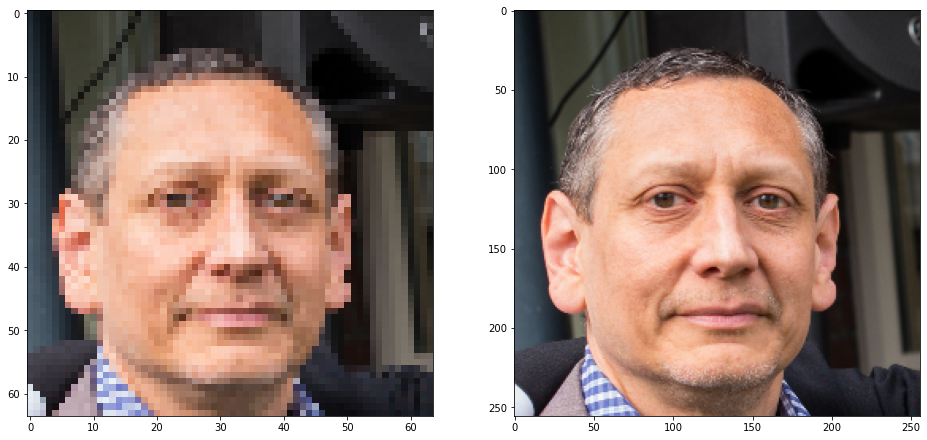

In [11]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(lr_list)-1)
plt.figure(figsize=(16, 16))
plt.subplot(121)
img_lr = cv2.imread("images/lr_images/" + lr_list[image_number])
img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
plt.imshow(img_lr)

plt.subplot(122)
img_hr = cv2.imread("images/hr_images/" + hr_list[image_number])
img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
plt.imshow(img_hr)
plt.show()

In [12]:
#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.20, random_state=42)



hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((256,256,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   15616       input_1[0][0]                    
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 64, 64, 64)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   36928       p_re_lu[0][0]                    
______________________________________________________________________________________________

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_33 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 128, 128, 128)     7385

In [13]:
#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 256, 256, 3)  2044291     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 1)            138912577   model[0][0]                      
____________________________________________________________________________________________

In [14]:
#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 8
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [15]:
epochs = 200
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")

100%|██████████| 500/500 [08:23<00:00,  1.01s/it]


epoch: 1 g_loss: 42.46462776374817 d_loss: [3.98375787 0.914125  ]


100%|██████████| 500/500 [08:06<00:00,  1.03it/s]


epoch: 2 g_loss: 19.868291563034056 d_loss: [0.5556983 0.9585   ]


100%|██████████| 500/500 [08:09<00:00,  1.02it/s]


epoch: 3 g_loss: 16.4856272315979 d_loss: [0.32756329 0.982125  ]


100%|██████████| 500/500 [08:09<00:00,  1.02it/s]


epoch: 4 g_loss: 14.850114751815797 d_loss: [9.17109001e-09 1.00000000e+00]


100%|██████████| 500/500 [08:07<00:00,  1.03it/s]


epoch: 5 g_loss: 14.244653032302857 d_loss: [0.98164818 0.9165    ]


100%|██████████| 500/500 [08:07<00:00,  1.03it/s]


epoch: 6 g_loss: 13.345816829681397 d_loss: [0.14663627 0.984625  ]


100%|██████████| 500/500 [08:08<00:00,  1.02it/s]


epoch: 7 g_loss: 1196.565778881073 d_loss: [0.28668606 0.981125  ]


100%|██████████| 500/500 [08:05<00:00,  1.03it/s]


epoch: 8 g_loss: 122.95473232269288 d_loss: [1.10657882 0.97425   ]


100%|██████████| 500/500 [08:05<00:00,  1.03it/s]


epoch: 9 g_loss: 72.748034324646 d_loss: [0.17040014 0.990375  ]


100%|██████████| 500/500 [08:06<00:00,  1.03it/s]

epoch: 10 g_loss: 51.57426816558838 d_loss: [1.01888455 0.975875  ]



C:\Users\Denys Pylypenko\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
100%|██████████| 500/500 [08:05<00:00,  1.03it/s]


epoch: 11 g_loss: 36.94858686065674 d_loss: [0.17053744 0.994     ]


100%|██████████| 500/500 [08:05<00:00,  1.03it/s]


epoch: 12 g_loss: 47.015057468414305 d_loss: [0.49440885 0.989     ]


100%|██████████| 500/500 [08:05<00:00,  1.03it/s]


epoch: 13 g_loss: 35.27637253189087 d_loss: [0.34882446 0.994875  ]


100%|██████████| 500/500 [08:06<00:00,  1.03it/s]


epoch: 14 g_loss: 28.969451042175294 d_loss: [1.32885545e-04 9.99875000e-01]


100%|██████████| 500/500 [08:05<00:00,  1.03it/s]


epoch: 15 g_loss: 27.542933444976807 d_loss: [0.37409084 0.994375  ]


100%|██████████| 500/500 [08:06<00:00,  1.03it/s]


epoch: 16 g_loss: 27.85814380264282 d_loss: [0.09578916 0.999125  ]


100%|██████████| 500/500 [08:04<00:00,  1.03it/s]


epoch: 17 g_loss: 26.516149166107176 d_loss: [0. 1.]


100%|██████████| 500/500 [08:05<00:00,  1.03it/s]


epoch: 18 g_loss: 25.51581080245972 d_loss: [0. 1.]


100%|██████████| 500/500 [08:06<00:00,  1.03it/s]


epoch: 19 g_loss: 24.673138973236085 d_loss: [0.80334828 0.9955    ]


100%|██████████| 500/500 [08:04<00:00,  1.03it/s]

epoch: 20 g_loss: 25.970877445220946 d_loss: [0.17185658 0.997875  ]



100%|██████████| 500/500 [08:05<00:00,  1.03it/s]


epoch: 21 g_loss: 25.477784606933593 d_loss: [0.16785433 0.998875  ]


100%|██████████| 500/500 [08:06<00:00,  1.03it/s]


epoch: 22 g_loss: 116.54955536651612 d_loss: [0.64742146 0.9955    ]


100%|██████████| 500/500 [08:05<00:00,  1.03it/s]


epoch: 23 g_loss: 33.558841911315916 d_loss: [0.7369666 0.994    ]


100%|██████████| 500/500 [08:05<00:00,  1.03it/s]


epoch: 24 g_loss: 26.552666843414308 d_loss: [3.04598631e-21 1.00000000e+00]


100%|██████████| 500/500 [08:06<00:00,  1.03it/s]


epoch: 25 g_loss: 24.49010092163086 d_loss: [3.07009333e-21 1.00000000e+00]


100%|██████████| 500/500 [08:04<00:00,  1.03it/s]


epoch: 26 g_loss: 23.790356357574463 d_loss: [3.04598631e-21 1.00000000e+00]


100%|██████████| 500/500 [08:05<00:00,  1.03it/s]


epoch: 27 g_loss: 26.38306297302246 d_loss: [1.06206242 0.992875  ]


100%|██████████| 500/500 [08:05<00:00,  1.03it/s]


epoch: 28 g_loss: 23.31080979537964 d_loss: [1.17621863e-38 1.00000000e+00]


100%|██████████| 500/500 [08:04<00:00,  1.03it/s]


epoch: 29 g_loss: 22.677611576080324 d_loss: [0. 1.]


100%|██████████| 500/500 [08:05<00:00,  1.03it/s]

epoch: 30 g_loss: 22.48748369216919 d_loss: [0.033138 0.999375]



100%|██████████| 500/500 [08:06<00:00,  1.03it/s]


epoch: 31 g_loss: 20.962012254714967 d_loss: [2.46499083e-07 1.00000000e+00]


100%|██████████| 500/500 [08:04<00:00,  1.03it/s]


epoch: 32 g_loss: 20.000443922042848 d_loss: [0. 1.]


100%|██████████| 500/500 [08:05<00:00,  1.03it/s]


epoch: 33 g_loss: 19.358359264373778 d_loss: [2.37455953e-15 1.00000000e+00]


100%|██████████| 500/500 [08:06<00:00,  1.03it/s]


epoch: 34 g_loss: 18.264351354599 d_loss: [0.81375812 0.99725   ]


100%|██████████| 500/500 [08:04<00:00,  1.03it/s]


epoch: 35 g_loss: 17.289845138549804 d_loss: [0.28126949 0.99825   ]


100%|██████████| 500/500 [08:05<00:00,  1.03it/s]


epoch: 36 g_loss: 655.8887503967285 d_loss: [1.11914128 0.997125  ]


100%|██████████| 500/500 [08:06<00:00,  1.03it/s]


epoch: 37 g_loss: 59.25283242797852 d_loss: [0.21580753 0.99925   ]


100%|██████████| 500/500 [08:05<00:00,  1.03it/s]


epoch: 38 g_loss: 31.282455360412598 d_loss: [0.01933125 0.999625  ]


100%|██████████| 500/500 [08:06<00:00,  1.03it/s]


epoch: 39 g_loss: 26.941297481536864 d_loss: [0. 1.]


100%|██████████| 500/500 [08:07<00:00,  1.03it/s]

epoch: 40 g_loss: 24.95800798034668 d_loss: [0. 1.]



100%|██████████| 500/500 [08:05<00:00,  1.03it/s]


epoch: 41 g_loss: 23.351640480041503 d_loss: [0. 1.]


100%|██████████| 500/500 [08:05<00:00,  1.03it/s]


epoch: 42 g_loss: 22.506575912475586 d_loss: [0. 1.]


100%|██████████| 500/500 [08:05<00:00,  1.03it/s]


epoch: 43 g_loss: 22.005938566207885 d_loss: [0. 1.]


100%|██████████| 500/500 [08:06<00:00,  1.03it/s]


epoch: 44 g_loss: 20.542546237945558 d_loss: [0. 1.]


100%|██████████| 500/500 [08:06<00:00,  1.03it/s]


epoch: 45 g_loss: 19.468107294082643 d_loss: [0. 1.]


100%|██████████| 500/500 [08:06<00:00,  1.03it/s]


epoch: 46 g_loss: 18.589283349990843 d_loss: [0. 1.]


100%|██████████| 500/500 [08:05<00:00,  1.03it/s]


epoch: 47 g_loss: 18.107840396881105 d_loss: [0. 1.]


100%|██████████| 500/500 [08:05<00:00,  1.03it/s]


epoch: 48 g_loss: 374.194717250824 d_loss: [0. 1.]


100%|██████████| 500/500 [08:09<00:00,  1.02it/s]


epoch: 49 g_loss: 71.18962284851074 d_loss: [4.91497956e-16 1.00000000e+00]


100%|██████████| 500/500 [08:05<00:00,  1.03it/s]

epoch: 50 g_loss: 48.08906239318848 d_loss: [0.74671643 0.9965    ]



100%|██████████| 500/500 [08:04<00:00,  1.03it/s]


epoch: 51 g_loss: 36.86538794708252 d_loss: [0.75506095 0.9955    ]


100%|██████████| 500/500 [08:05<00:00,  1.03it/s]


epoch: 52 g_loss: 29.197801052093507 d_loss: [0. 1.]


100%|██████████| 500/500 [08:04<00:00,  1.03it/s]


epoch: 53 g_loss: 25.406221237182617 d_loss: [0. 1.]


100%|██████████| 500/500 [08:05<00:00,  1.03it/s]


epoch: 54 g_loss: 23.90086455154419 d_loss: [0. 1.]


100%|██████████| 500/500 [08:05<00:00,  1.03it/s]


epoch: 55 g_loss: 22.450876834869383 d_loss: [0. 1.]


100%|██████████| 500/500 [08:08<00:00,  1.02it/s]


epoch: 56 g_loss: 21.428282442092897 d_loss: [0. 1.]


100%|██████████| 500/500 [08:06<00:00,  1.03it/s]


epoch: 57 g_loss: 20.37835415458679 d_loss: [0. 1.]


100%|██████████| 500/500 [08:04<00:00,  1.03it/s]


epoch: 58 g_loss: 19.604966020584108 d_loss: [0. 1.]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 59 g_loss: 18.883107902526856 d_loss: [0. 1.]


100%|██████████| 500/500 [08:03<00:00,  1.03it/s]

epoch: 60 g_loss: 18.038837196350098 d_loss: [0. 1.]



100%|██████████| 500/500 [08:21<00:00,  1.00s/it]


epoch: 61 g_loss: 17.66299768447876 d_loss: [0. 1.]


100%|██████████| 500/500 [08:09<00:00,  1.02it/s]


epoch: 62 g_loss: 18.282876501083376 d_loss: [0. 1.]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 63 g_loss: 17.08389662361145 d_loss: [0. 1.]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 64 g_loss: 16.90981322097778 d_loss: [0.51708094 0.997125  ]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 65 g_loss: 17.8188967628479 d_loss: [0. 1.]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 66 g_loss: 16.654088720321656 d_loss: [0. 1.]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 67 g_loss: 16.573431818008423 d_loss: [0. 1.]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 68 g_loss: 16.5639508934021 d_loss: [0.61949474 0.99825   ]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 69 g_loss: 16.70268660545349 d_loss: [0.04949061 0.999375  ]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]

epoch: 70 g_loss: 2065.3106003952025 d_loss: [1.22922989 0.995     ]



100%|██████████| 500/500 [08:00<00:00,  1.04it/s]


epoch: 71 g_loss: 63.268270568847655 d_loss: [0.69446507 0.996     ]


100%|██████████| 500/500 [08:01<00:00,  1.04it/s]


epoch: 72 g_loss: 49.82911208343506 d_loss: [0.06537181 0.9995    ]


100%|██████████| 500/500 [08:01<00:00,  1.04it/s]


epoch: 73 g_loss: 44.050940811157226 d_loss: [0.77156837 0.996625  ]


100%|██████████| 500/500 [08:00<00:00,  1.04it/s]


epoch: 74 g_loss: 40.57730562591553 d_loss: [0.0373813 0.999375 ]


100%|██████████| 500/500 [08:01<00:00,  1.04it/s]


epoch: 75 g_loss: 36.24708415603638 d_loss: [1.49904318e-19 1.00000000e+00]


100%|██████████| 500/500 [08:03<00:00,  1.03it/s]


epoch: 76 g_loss: 30.278530784606932 d_loss: [1.49904318e-19 1.00000000e+00]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 77 g_loss: 27.241707038879394 d_loss: [1.49904318e-19 1.00000000e+00]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 78 g_loss: 25.151523971557616 d_loss: [1.49904318e-19 1.00000000e+00]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 79 g_loss: 24.48894690322876 d_loss: [1.49904318e-19 1.00000000e+00]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]

epoch: 80 g_loss: 32.26191443824768 d_loss: [1.39093923 0.994375  ]



100%|██████████| 500/500 [08:03<00:00,  1.03it/s]


epoch: 81 g_loss: 26.983820114135742 d_loss: [0.00490543 0.99975   ]


100%|██████████| 500/500 [08:03<00:00,  1.03it/s]


epoch: 82 g_loss: 21.660057294845583 d_loss: [4.88379225e-25 1.00000000e+00]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 83 g_loss: 19.8025949344635 d_loss: [4.88379225e-25 1.00000000e+00]


100%|██████████| 500/500 [08:03<00:00,  1.03it/s]


epoch: 84 g_loss: 18.90774005508423 d_loss: [4.88379225e-25 1.00000000e+00]


100%|██████████| 500/500 [08:03<00:00,  1.03it/s]


epoch: 85 g_loss: 18.808633892059326 d_loss: [4.88379225e-25 1.00000000e+00]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 86 g_loss: 19.59036847496033 d_loss: [3.68867164e-19 1.00000000e+00]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 87 g_loss: 17.65336078262329 d_loss: [4.88379225e-25 1.00000000e+00]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 88 g_loss: 18.242766626358033 d_loss: [0.95806974 0.997375  ]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 89 g_loss: 17.22361700630188 d_loss: [6.87141806e-35 1.00000000e+00]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]

epoch: 90 g_loss: 16.94554982185364 d_loss: [6.87141806e-35 1.00000000e+00]



100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 91 g_loss: 26.023320571899415 d_loss: [0.55792745 0.99675   ]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 92 g_loss: 20.310543292999267 d_loss: [0.06242722 0.99975   ]


100%|██████████| 500/500 [08:20<00:00,  1.00s/it]


epoch: 93 g_loss: 17.050931200027467 d_loss: [3.62706e-23 1.00000e+00]


100%|██████████| 500/500 [08:21<00:00,  1.00s/it]


epoch: 94 g_loss: 16.776437831878663 d_loss: [0.08150264 0.999125  ]


100%|██████████| 500/500 [08:20<00:00,  1.00s/it]


epoch: 95 g_loss: 16.423685356140137 d_loss: [0.02039433 0.999875  ]


100%|██████████| 500/500 [08:21<00:00,  1.00s/it]


epoch: 96 g_loss: 16.50312482070923 d_loss: [0. 1.]


100%|██████████| 500/500 [08:21<00:00,  1.00s/it]


epoch: 97 g_loss: 16.20040157699585 d_loss: [0. 1.]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 98 g_loss: 16.360845657348634 d_loss: [0. 1.]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 99 g_loss: 16.199679710388185 d_loss: [0. 1.]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]

epoch: 100 g_loss: 15.499667417526245 d_loss: [0. 1.]



100%|██████████| 500/500 [08:01<00:00,  1.04it/s]


epoch: 101 g_loss: 15.07952481842041 d_loss: [0. 1.]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 102 g_loss: 14.768901872634888 d_loss: [0. 1.]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 103 g_loss: 308.11308124542234 d_loss: [0.29093097 0.9985    ]


100%|██████████| 500/500 [08:00<00:00,  1.04it/s]


epoch: 104 g_loss: 99.13173699188232 d_loss: [1.40739731 0.992875  ]


100%|██████████| 500/500 [08:01<00:00,  1.04it/s]


epoch: 105 g_loss: 42.32880192565918 d_loss: [0.0718663 0.999125 ]


100%|██████████| 500/500 [08:01<00:00,  1.04it/s]


epoch: 106 g_loss: 29.247115669250487 d_loss: [0.0314403 0.999625 ]


100%|██████████| 500/500 [08:00<00:00,  1.04it/s]


epoch: 107 g_loss: 26.584517166137694 d_loss: [3.59266e-38 1.00000e+00]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 108 g_loss: 23.70769105911255 d_loss: [3.59266e-38 1.00000e+00]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 109 g_loss: 22.5386373462677 d_loss: [0.30090067 0.99825   ]


100%|██████████| 500/500 [08:01<00:00,  1.04it/s]

epoch: 110 g_loss: 21.08808994102478 d_loss: [0.24927612 0.9995    ]



100%|██████████| 500/500 [08:03<00:00,  1.03it/s]


epoch: 111 g_loss: 19.700161745071412 d_loss: [0. 1.]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 112 g_loss: 18.907948211669922 d_loss: [0. 1.]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 113 g_loss: 18.585340393066407 d_loss: [0. 1.]


100%|██████████| 500/500 [08:03<00:00,  1.03it/s]


epoch: 114 g_loss: 18.378293209075927 d_loss: [0. 1.]


100%|██████████| 500/500 [08:03<00:00,  1.04it/s]


epoch: 115 g_loss: 16.71481571960449 d_loss: [0. 1.]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 116 g_loss: 16.133585718154908 d_loss: [0. 1.]


100%|██████████| 500/500 [08:03<00:00,  1.03it/s]


epoch: 117 g_loss: 15.796298473358155 d_loss: [0. 1.]


100%|██████████| 500/500 [08:04<00:00,  1.03it/s]


epoch: 118 g_loss: 22.803033338546754 d_loss: [1.0768366 0.996    ]


100%|██████████| 500/500 [08:09<00:00,  1.02it/s]


epoch: 119 g_loss: 15.890076679229736 d_loss: [0.41969935 0.9985    ]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]

epoch: 120 g_loss: 15.189847366333009 d_loss: [0. 1.]



100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 121 g_loss: 14.750321704864502 d_loss: [0. 1.]


100%|██████████| 500/500 [08:01<00:00,  1.04it/s]


epoch: 122 g_loss: 15.09246632385254 d_loss: [0.32601984 0.997875  ]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 123 g_loss: 14.214394889831542 d_loss: [0. 1.]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 124 g_loss: 14.176138660430908 d_loss: [0. 1.]


100%|██████████| 500/500 [08:01<00:00,  1.04it/s]


epoch: 125 g_loss: 13.52035637664795 d_loss: [1.13147248 0.99425   ]


100%|██████████| 500/500 [08:01<00:00,  1.04it/s]


epoch: 126 g_loss: 13.182094680786133 d_loss: [0.16524962 0.99725   ]


100%|██████████| 500/500 [08:01<00:00,  1.04it/s]


epoch: 127 g_loss: 12.950575540542603 d_loss: [0. 1.]


100%|██████████| 500/500 [08:01<00:00,  1.04it/s]


epoch: 128 g_loss: 12.746712911605835 d_loss: [1.21826154e-34 1.00000000e+00]


100%|██████████| 500/500 [08:00<00:00,  1.04it/s]


epoch: 129 g_loss: 12.610398649215698 d_loss: [7.85992704e-06 1.00000000e+00]


100%|██████████| 500/500 [08:00<00:00,  1.04it/s]

epoch: 130 g_loss: 12.469881303787231 d_loss: [0. 1.]



100%|██████████| 500/500 [08:01<00:00,  1.04it/s]


epoch: 131 g_loss: 12.153556400299072 d_loss: [0. 1.]


100%|██████████| 500/500 [08:01<00:00,  1.04it/s]


epoch: 132 g_loss: 12.084093130111695 d_loss: [0.57596968 0.99825   ]


100%|██████████| 500/500 [08:01<00:00,  1.04it/s]


epoch: 133 g_loss: 75.44986844444274 d_loss: [0.03188472 0.999625  ]


100%|██████████| 500/500 [08:01<00:00,  1.04it/s]


epoch: 134 g_loss: 25.75678153038025 d_loss: [0.0115862 0.999875 ]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 135 g_loss: 17.885797044754028 d_loss: [0.07394131 0.9995    ]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 136 g_loss: 16.52296508216858 d_loss: [0. 1.]


100%|██████████| 500/500 [08:01<00:00,  1.04it/s]


epoch: 137 g_loss: 15.776198135375976 d_loss: [1.53242547 0.9945    ]


100%|██████████| 500/500 [08:01<00:00,  1.04it/s]


epoch: 138 g_loss: 14.673743095397949 d_loss: [0. 1.]


100%|██████████| 500/500 [08:01<00:00,  1.04it/s]


epoch: 139 g_loss: 13.855511138916016 d_loss: [0.20383162 0.9985    ]


100%|██████████| 500/500 [08:01<00:00,  1.04it/s]

epoch: 140 g_loss: 13.22241035079956 d_loss: [0.03561321 0.999375  ]



100%|██████████| 500/500 [08:03<00:00,  1.03it/s]


epoch: 141 g_loss: 13.087004474639892 d_loss: [1.05616874 0.992375  ]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 142 g_loss: 12.83161416053772 d_loss: [0.10034073 0.9985    ]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 143 g_loss: 12.352638868331908 d_loss: [0.20908587 0.99725   ]


100%|██████████| 500/500 [08:11<00:00,  1.02it/s]


epoch: 144 g_loss: 12.29004998588562 d_loss: [0.76986293 0.996125  ]


100%|██████████| 500/500 [08:07<00:00,  1.02it/s]


epoch: 145 g_loss: 11.82983101272583 d_loss: [0.01231022 0.99975   ]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 146 g_loss: 11.673977637290955 d_loss: [0.00413288 0.999875  ]


100%|██████████| 500/500 [08:12<00:00,  1.02it/s]


epoch: 147 g_loss: 11.66275452709198 d_loss: [0.06535017 0.99925   ]


100%|██████████| 500/500 [08:04<00:00,  1.03it/s]


epoch: 148 g_loss: 11.479804240226745 d_loss: [0.04587423 0.999375  ]


100%|██████████| 500/500 [08:05<00:00,  1.03it/s]


epoch: 149 g_loss: 11.167975994110108 d_loss: [0. 1.]


100%|██████████| 500/500 [08:13<00:00,  1.01it/s]

epoch: 150 g_loss: 11.10088933467865 d_loss: [0. 1.]



100%|██████████| 500/500 [08:10<00:00,  1.02it/s]


epoch: 151 g_loss: 19.279718797683717 d_loss: [0. 1.]


100%|██████████| 500/500 [08:09<00:00,  1.02it/s]


epoch: 152 g_loss: 11.781909297943114 d_loss: [0. 1.]


100%|██████████| 500/500 [08:04<00:00,  1.03it/s]


epoch: 153 g_loss: 11.163386865615845 d_loss: [0. 1.]


100%|██████████| 500/500 [08:03<00:00,  1.04it/s]


epoch: 154 g_loss: 10.908692210197449 d_loss: [0. 1.]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 155 g_loss: 10.74959731578827 d_loss: [0. 1.]


100%|██████████| 500/500 [08:03<00:00,  1.03it/s]


epoch: 156 g_loss: 10.624793019294739 d_loss: [0. 1.]


100%|██████████| 500/500 [08:03<00:00,  1.03it/s]


epoch: 157 g_loss: 10.523381392478942 d_loss: [0. 1.]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 158 g_loss: 10.453073506355286 d_loss: [0.54361933 0.99675   ]


100%|██████████| 500/500 [08:03<00:00,  1.03it/s]


epoch: 159 g_loss: 40.39552403831482 d_loss: [0.3948342 0.9975   ]


100%|██████████| 500/500 [08:06<00:00,  1.03it/s]

epoch: 160 g_loss: 17.67574232673645 d_loss: [0.08382787 0.998375  ]



100%|██████████| 500/500 [08:17<00:00,  1.01it/s]


epoch: 161 g_loss: 14.052345928192139 d_loss: [0.61200184 0.996375  ]


100%|██████████| 500/500 [08:10<00:00,  1.02it/s]


epoch: 162 g_loss: 12.716918500900269 d_loss: [0.01012162 0.99975   ]


100%|██████████| 500/500 [08:11<00:00,  1.02it/s]


epoch: 163 g_loss: 11.96319540977478 d_loss: [0.14097982 0.998125  ]


100%|██████████| 500/500 [08:09<00:00,  1.02it/s]


epoch: 164 g_loss: 11.58485632610321 d_loss: [0.74076101 0.994125  ]


100%|██████████| 500/500 [08:09<00:00,  1.02it/s]


epoch: 165 g_loss: 11.229994610786438 d_loss: [0.01001018 0.999875  ]


100%|██████████| 500/500 [08:10<00:00,  1.02it/s]


epoch: 166 g_loss: 12.218843300819398 d_loss: [0.0108438 0.999625 ]


100%|██████████| 500/500 [08:10<00:00,  1.02it/s]


epoch: 167 g_loss: 10.819927131652832 d_loss: [3.64258242e-04 9.99875000e-01]


100%|██████████| 500/500 [08:14<00:00,  1.01it/s]


epoch: 168 g_loss: 10.632587054252625 d_loss: [1.63191271e-34 1.00000000e+00]


100%|██████████| 500/500 [08:09<00:00,  1.02it/s]


epoch: 169 g_loss: 10.51229821395874 d_loss: [0. 1.]


100%|██████████| 500/500 [08:01<00:00,  1.04it/s]

epoch: 170 g_loss: 10.379762886047363 d_loss: [1.95955841e-30 1.00000000e+00]



100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 171 g_loss: 10.281650298118592 d_loss: [0. 1.]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 172 g_loss: 10.279870450019837 d_loss: [0.97258824 0.99325   ]


100%|██████████| 500/500 [08:01<00:00,  1.04it/s]


epoch: 173 g_loss: 10.021450063705444 d_loss: [0.1484284 0.998375 ]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 174 g_loss: 9.936890909194947 d_loss: [0.02443681 0.9995    ]


100%|██████████| 500/500 [08:03<00:00,  1.03it/s]


epoch: 175 g_loss: 9.850701854705811 d_loss: [0.00206231 0.999875  ]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 176 g_loss: 9.70031093788147 d_loss: [0. 1.]


100%|██████████| 500/500 [08:04<00:00,  1.03it/s]


epoch: 177 g_loss: 9.538994801521302 d_loss: [0. 1.]


100%|██████████| 500/500 [08:08<00:00,  1.02it/s]


epoch: 178 g_loss: 489.2064348077774 d_loss: [0.90792559 0.995875  ]


100%|██████████| 500/500 [08:06<00:00,  1.03it/s]


epoch: 179 g_loss: 39.88430271148682 d_loss: [0.01210477 0.999875  ]


100%|██████████| 500/500 [08:01<00:00,  1.04it/s]

epoch: 180 g_loss: 27.065819137573243 d_loss: [0. 1.]



100%|██████████| 500/500 [08:01<00:00,  1.04it/s]


epoch: 181 g_loss: 22.74209526062012 d_loss: [0. 1.]


100%|██████████| 500/500 [08:01<00:00,  1.04it/s]


epoch: 182 g_loss: 20.310255798339846 d_loss: [0. 1.]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 183 g_loss: 17.90379461479187 d_loss: [0. 1.]


100%|██████████| 500/500 [08:01<00:00,  1.04it/s]


epoch: 184 g_loss: 19.263613138198853 d_loss: [0. 1.]


100%|██████████| 500/500 [08:01<00:00,  1.04it/s]


epoch: 185 g_loss: 16.14443305015564 d_loss: [0. 1.]


100%|██████████| 500/500 [08:01<00:00,  1.04it/s]


epoch: 186 g_loss: 18.273426988601685 d_loss: [0. 1.]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 187 g_loss: 13.669621971130372 d_loss: [0. 1.]


100%|██████████| 500/500 [08:01<00:00,  1.04it/s]


epoch: 188 g_loss: 12.610281200408936 d_loss: [0. 1.]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 189 g_loss: 12.751330461502075 d_loss: [0. 1.]


100%|██████████| 500/500 [08:01<00:00,  1.04it/s]

epoch: 190 g_loss: 11.510160276412964 d_loss: [0. 1.]



100%|██████████| 500/500 [08:00<00:00,  1.04it/s]


epoch: 191 g_loss: 11.242004699707032 d_loss: [0. 1.]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 192 g_loss: 10.951342118263245 d_loss: [0. 1.]


100%|██████████| 500/500 [08:01<00:00,  1.04it/s]


epoch: 193 g_loss: 10.731164972305297 d_loss: [0.17094915 0.998125  ]


100%|██████████| 500/500 [08:00<00:00,  1.04it/s]


epoch: 194 g_loss: 20.098019101142885 d_loss: [0. 1.]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 195 g_loss: 11.037510365486146 d_loss: [0. 1.]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 196 g_loss: 10.318683693885804 d_loss: [0. 1.]


100%|██████████| 500/500 [08:01<00:00,  1.04it/s]


epoch: 197 g_loss: 10.034529550552367 d_loss: [0. 1.]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 198 g_loss: 10.020864163398743 d_loss: [1.44819247 0.99475   ]


100%|██████████| 500/500 [08:02<00:00,  1.04it/s]


epoch: 199 g_loss: 10.151338889122009 d_loss: [0. 1.]


100%|██████████| 500/500 [08:01<00:00,  1.04it/s]

epoch: 200 g_loss: 9.821614726066588 d_loss: [0. 1.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


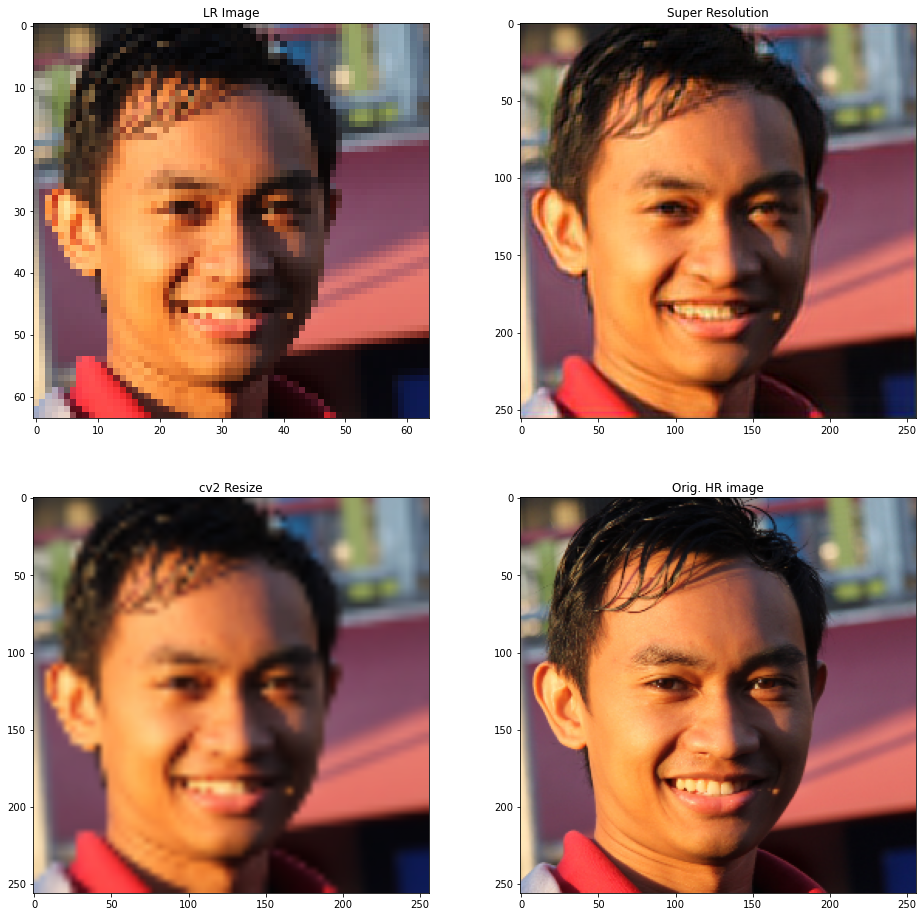

In [60]:
from keras.models import load_model
from numpy.random import randint

[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 16))
plt.subplot(221)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(222)
plt.title('Super Resolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(223)
plt.title('cv2 Resize')
plt.imshow(
    cv2.resize(src_image[0,:,:,:], (256,256))
)
plt.subplot(224)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()
